In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect,and_

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
base=automap_base()
# reflect the tables
base.prepare(engine,reflect=True)

In [8]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement=base.classes.measurement
Station=base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

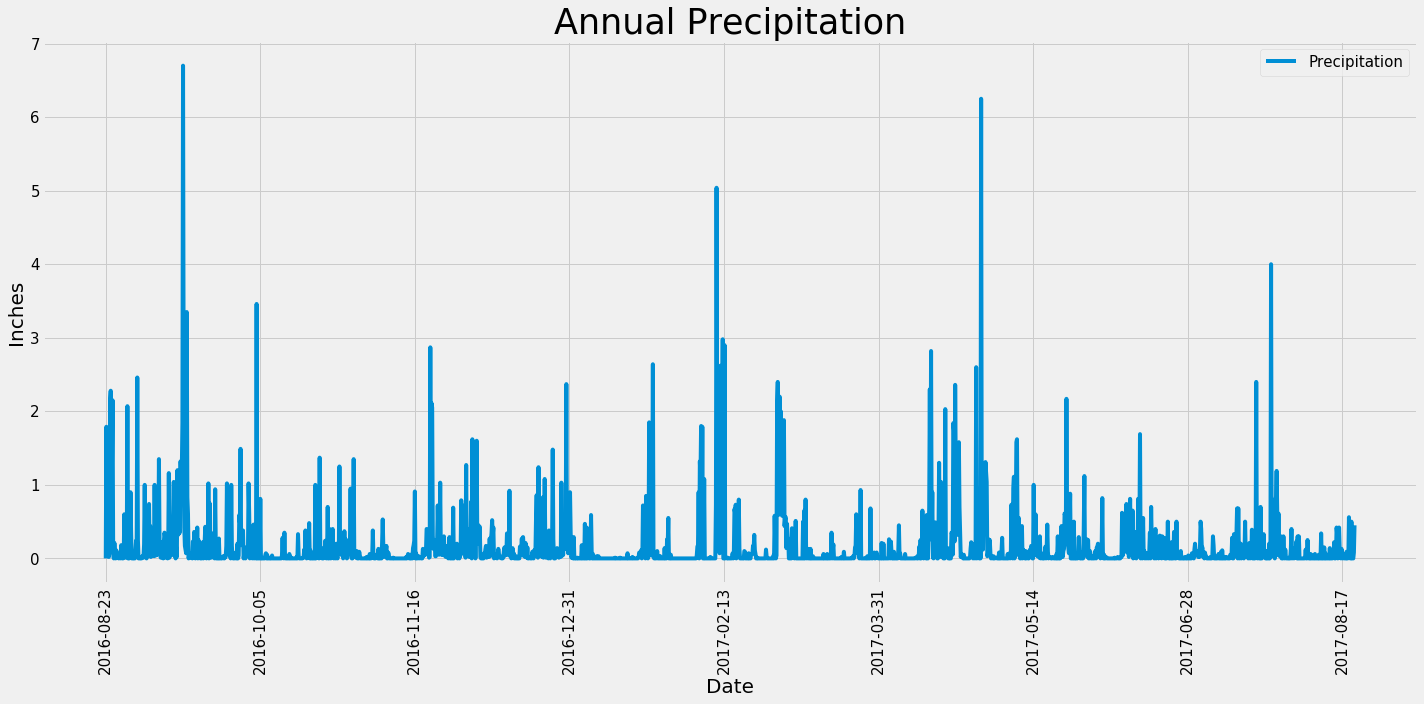

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_point=session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Perform a query to retrieve the data and precipitation scores
data=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=( dt.datetime.strptime(last_point[0],'%Y-%m-%d') - dt.timedelta(days=366))).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data_df=pd.DataFrame(data)
data_df=data_df.set_index("date")

# Sort the dataframe by date
sorted_df=data_df.sort_index().dropna(how='any')

# Use Pandas Plotting with Matplotlib to plot the data
pandas_bar=sorted_df.plot(figsize=(20,10))
plt.title("Annual Precipitation",fontSize=35)
plt.xticks(fontSize=15,rotation ="vertical")
plt.yticks(fontSize=15)
plt.ylabel("Inches",fontSize=20)
plt.xlabel("Date",fontSize=20)
plt.legend(["Precipitation"],fontsize=15)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [13]:
# Design a query to show how many stations are available in this dataset
count_station=session.query(Measurement.station).distinct().count()
count_station

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
act_station=session.query(Measurement.station,func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
act_station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
#TO DO DATA FRAME
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
result=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station==act_station[0][0]).all()
result


[(54.0, 85.0, 71.66378066378067)]

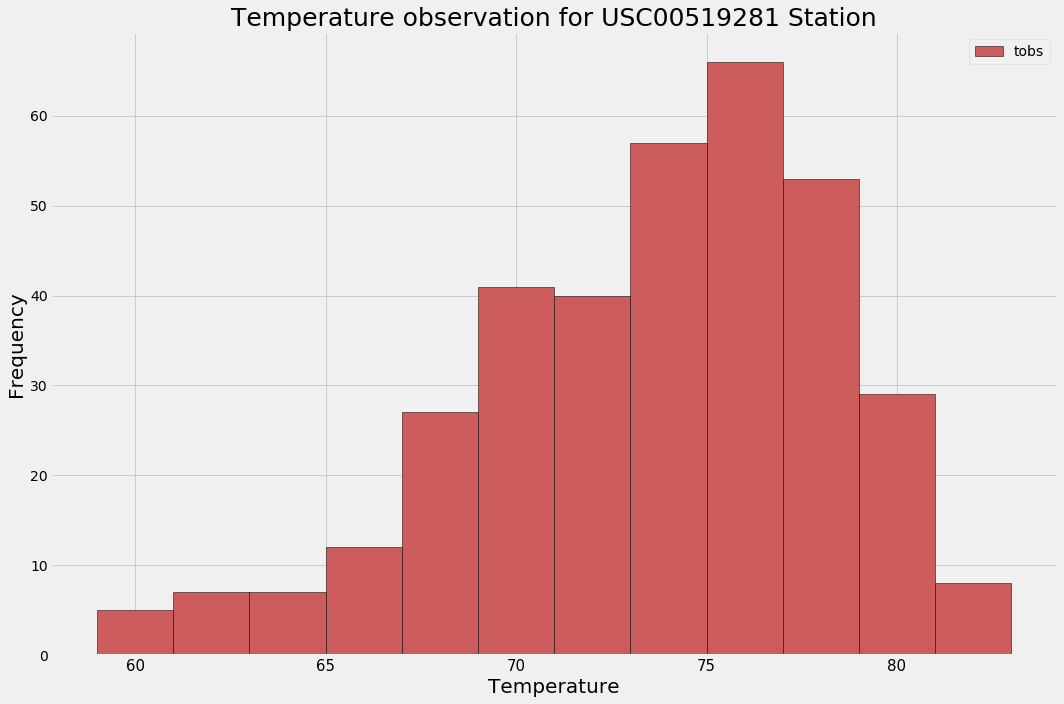

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_data=session.query(Measurement.station,Measurement.tobs).filter(and_(Measurement.station=='USC00519281', Measurement.date>=( dt.datetime.strptime(last_point[0],'%Y-%m-%d') - dt.timedelta(days=366)))).all()
station_data_df=pd.DataFrame(station_data)
station_data_df=station_data_df.set_index('station')

station_data_df.plot.hist(bins=12,figsize=(15,10),color='indianred',alpha=1,edgecolor='black')
plt.title("Temperature observation for USC00519281 Station",fontSize=25)
plt.xticks(fontSize=15)
plt.xlabel("Temperature",fontSize=20)
plt.ylabel("Frequency",fontSize=20)
plt.tight_layout()
plt.show()


## Temperature Analysis I

In [17]:
from scipy import stats
from scipy import mean

#Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

dt.date.today().strftime("%m")

date_june='06'
june_avg=session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == date_june).all()
june_result=list(np.ravel(june_avg))
print (f'June average temperature is {june_result[0]}')

# December temperature.

date_dec='12'
dec_avg=session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == date_dec).all()
dec_result=list(np.ravel(dec_avg))
print (f'December average temperature is {dec_result[0]}')




June average temperature is 74.94411764705882
December average temperature is 71.04152933421226


In [18]:
#Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test?

june_query=session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == date_june).all()
june_query_result=list(np.ravel(june_query))
june_query_result


dec_query=session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == date_dec).all()
dec_query_result=list(np.ravel(dec_query))
dec_query_result

stat=stats.ttest_ind(june_query_result,dec_query_result)
stat

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
        
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [56]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date='2016-10-01'
end_date='2016-10-10'

vac_result=list(np.ravel(calc_temps(start_date, end_date)))

vac_result

[71.0, 77.53968253968254, 82.0]

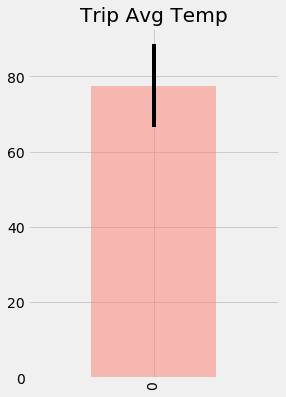

In [58]:
# Plot the results from your previous query as a bar chart. 


temp_df=pd.DataFrame({"min temp":vac_result[0],
                       "avg temp":vac_result[1],
                       "max temp":vac_result[2]},index=[0])
             

temp_df.plot.bar(y='avg temp', yerr=(temp_df["max temp"] - temp_df["min temp"]) ,title='Trip Avg Temp', color='salmon', alpha=0.5, figsize=(4,6),legend=False)


# Use "Trip Avg Temp" as your Title

# Use the average temperature for the y value

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [80]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

normals=session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).group_by(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation).filter(Measurement.station==Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).order_by(func.count(Measurement.id).desc()).all()
normals






[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.25),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  6.449999999999999),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.4),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.07),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.14),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.07)]

In [93]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [133]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip


# Use the start and end date to create a range of dates
range_dates=pd.date_range(start=start_date, end=end_date)
range_dates

# Stip off the year and save a list of %m-%d strings
trip_date=[(date, date.strftime("%m-%d")) for date in range_dates]
trip_date


# Loop through the list of %m-%d strings and calculate the normals for each date
norm_date=[]
for shot_date in trip_date:
    data={}
    data["trip_date"]=shot_date[0]
    daily_normal=daily_normals(shot_date[1])
    data["tmin"]=daily_normal[0][0]
    data["tavg"]=daily_normal[0][1]
    data["tmax"]=daily_normal[0][2]
    norm_date.append(data)


norm_date
df=pd.DataFrame(norm_date)
df_trip=df.set_index("trip_date")
df_trip

,tmin,tavg,tmax
trip_date,,,
2016-10-01,69.0,75.229167,80.0
2016-10-02,70.0,76.260000,83.0
2016-10-03,66.0,76.730769,84.0
2016-10-04,67.0,75.862745,82.0
2016-10-05,67.0,76.166667,84.0
2016-10-06,70.0,75.420000,81.0
2016-10-07,68.0,75.607843,81.0
2016-10-08,66.0,76.326531,86.0
2016-10-09,69.0,76.113636,84.0


Text(0, 0.5, 'Temp (F)')

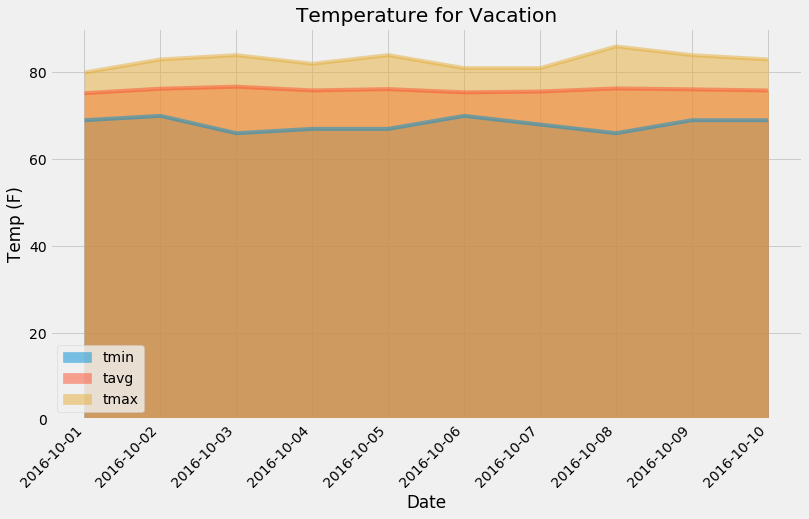

In [170]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


df_trip.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, title='Temperature for Vacation', rot=45)

plt.xlabel('Date')
plt.ylabel('Temp (F)')


